# Transfer Learning with Keras

In this example, we'll use a pretrained convnet to boost the performance on a small dataset. The dataset is taken from the cats vs dogs challenge on [Kaggle](https://www.kaggle.com/c/dogs-vs-cats/data). Using a network pretrained on ImageNet allows us to leverage the learned features from a general task and fine-tune them for the more specific task of identifying cats and dogs. The idea is that a model trained on a large-scale dataset will learn a generic model for the visual world which could be useful even though we are using them for a different task.

If the dataset hasn't been created, first download and extract the Kaggle dataset, then run the following python script from the terminal:
```
python3 make_cats_and_dogs_dataset.py
```

There are varying levels of transfer learning. We can use the pretrained convolutional network as a feature extractor and train a classifier on top of this or we can take a pre-trained network and fine-tune the weights. 

## Feature Extraction
The paper [CNN Features: Off-the-shelf](https://www.cv-foundation.org/openaccess/content_cvpr_workshops_2014/W15/html/Razavian_CNN_Features_Off-the-Shelf_2014_CVPR_paper.html) confirms the effectiveness of pretrained CNNs as a feature extractor for various image recognition tasks. We will follow the approach of this paper in taking and freezing the convolutional base of the pre-trained network, discarding the fully connected layers and retraining a new classifier on the convolutional base.



In [11]:
# select GPU
%env CUDA_VISIBLE_DEVICES=0

from keras.applications.vgg16 import VGG16
import os

conv_base = VGG16(include_top=False, weights='imagenet', input_shape=(150, 150, 3))

env: CUDA_VISIBLE_DEVICES=0


Now let's add the the convolutional base to our model with dense fully connected layers on top

In [16]:
from keras import models
from keras.layers import Flatten, Dense, Dropout

model = models.Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


Now, we freeze the pre-trained weights so that they don't change during the transfer learning process.

In [17]:
for layer in conv_base.layers:
    layer.trainable = False

print('Trainable layers: ', len(model.trainable_weights))

Trainable layers:  4


Now, only the two Dense layers contain trainable weights. They contain two per layer: the main weight matrix and the bias vector.

Now we can start training the model using data augmentation to reduce overfitting.

In [18]:
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop

target_size = (150, 150)
batch_size = 16
learning_rate = 2e-5
epochs=50

train_dir = os.path.join('data', 'cats_and_dogs_small', 'train')
validation_dir = os.path.join('data', 'cats_and_dogs_small', 'validation')

train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size=target_size,
                                                   batch_size=batch_size,
                                                   class_mode='binary')

validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                       target_size=target_size,
                                                       batch_size=batch_size,
                                                       class_mode='binary')

model.compile(loss='binary_crossentropy',
             optimizer=RMSprop(lr=learning_rate),
             metrics=['acc'])

history = model.fit_generator(train_generator,
                             steps_per_epoch=100,
                             epochs=epochs,
                             validation_data=validation_generator,
                             validation_steps=50,
                             verbose=2)

Found 2001 images belonging to 2 classes.
Found 1005 images belonging to 2 classes.
Epoch 1/50
 - 28s - loss: 0.6048 - acc: 0.6813 - val_loss: 0.4768 - val_acc: 0.8000
Epoch 2/50
 - 24s - loss: 0.4922 - acc: 0.7912 - val_loss: 0.3885 - val_acc: 0.8488
Epoch 3/50
 - 23s - loss: 0.4669 - acc: 0.7825 - val_loss: 0.3436 - val_acc: 0.8538
Epoch 4/50
 - 25s - loss: 0.3994 - acc: 0.8256 - val_loss: 0.3122 - val_acc: 0.8800
Epoch 5/50
 - 23s - loss: 0.3906 - acc: 0.8200 - val_loss: 0.2917 - val_acc: 0.8862
Epoch 6/50
 - 25s - loss: 0.3687 - acc: 0.8326 - val_loss: 0.2870 - val_acc: 0.8875
Epoch 7/50
 - 24s - loss: 0.3856 - acc: 0.8350 - val_loss: 0.2747 - val_acc: 0.8912
Epoch 8/50
 - 23s - loss: 0.3331 - acc: 0.8481 - val_loss: 0.2721 - val_acc: 0.8912
Epoch 9/50
 - 24s - loss: 0.3528 - acc: 0.8431 - val_loss: 0.2618 - val_acc: 0.8962
Epoch 10/50
 - 24s - loss: 0.3487 - acc: 0.8469 - val_loss: 0.2562 - val_acc: 0.8988
Epoch 11/50
 - 25s - loss: 0.3335 - acc: 0.8475 - val_loss: 0.2551 - val_ac

Let's plot the results.

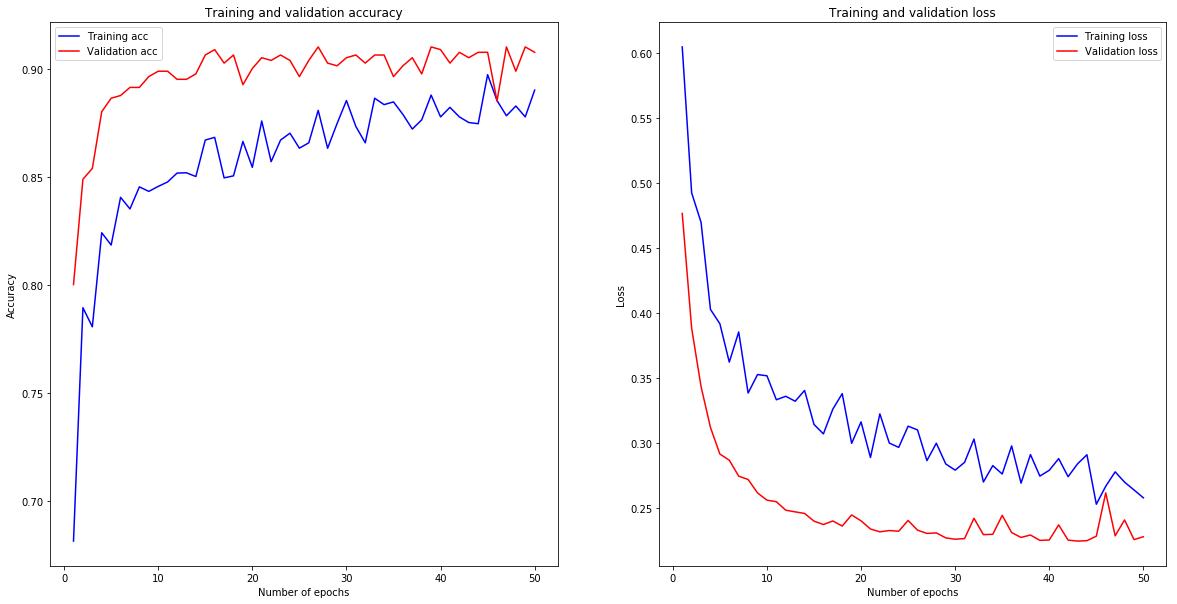

In [19]:
import matplotlib.pyplot as plt

ys = range(1, epochs + 1)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.plot(ys, history.history['acc'], 'b-', label='Training acc')
ax1.plot(ys, history.history['val_acc'], 'r-', label='Validation acc')
ax1.set_title('Training and validation accuracy')
ax1.set_xlabel('Number of epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(ys, history.history['loss'], 'b-', label='Training loss')
ax2.plot(ys, history.history['val_loss'], 'r-', label='Validation loss')
ax2.set_title('Training and validation loss')
ax2.set_xlabel('Number of epochs')
ax2.set_ylabel('Loss')
ax2.legend()

plt.show()

In [20]:
model.save('models/vgg-cats-dogs-classifier.hdf5')

## Fine-tuning

We can further increase the performance of the network by fine-tuning the top convolutional layers. It is necessary to first train the classifier as we have just done, otherwise the error propagating through backprop will destroy the pre-trained convolutional features.

In [21]:
# freeze the first 14 layers
conv_base.trainable = True
for layer in conv_base.layers[:14]:
    layer.trainable = False
    
# recompile the model
learning_rate=1e-5
model.compile(loss='binary_crossentropy',
             optimizer=RMSprop(lr=learning_rate),
             metrics=['accuracy'])

# refit the model
history = model.fit_generator(train_generator,
                             steps_per_epoch=100,
                             epochs=epochs,
                             validation_data=validation_generator,
                             validation_steps=50,
                             verbose=2)

Epoch 1/50
 - 27s - loss: 0.2813 - acc: 0.8756 - val_loss: 0.2339 - val_acc: 0.9025
Epoch 2/50
 - 24s - loss: 0.2460 - acc: 0.9038 - val_loss: 0.2283 - val_acc: 0.9100
Epoch 3/50
 - 24s - loss: 0.2579 - acc: 0.8900 - val_loss: 0.2306 - val_acc: 0.9000
Epoch 4/50
 - 24s - loss: 0.2697 - acc: 0.8881 - val_loss: 0.2264 - val_acc: 0.9050
Epoch 5/50
 - 24s - loss: 0.2542 - acc: 0.8812 - val_loss: 0.2261 - val_acc: 0.9075
Epoch 6/50
 - 26s - loss: 0.2714 - acc: 0.8756 - val_loss: 0.2271 - val_acc: 0.9087
Epoch 7/50
 - 24s - loss: 0.2532 - acc: 0.8876 - val_loss: 0.2278 - val_acc: 0.9075
Epoch 8/50
 - 25s - loss: 0.2632 - acc: 0.8875 - val_loss: 0.2263 - val_acc: 0.9038
Epoch 9/50
 - 23s - loss: 0.2546 - acc: 0.8956 - val_loss: 0.2267 - val_acc: 0.9050
Epoch 10/50
 - 24s - loss: 0.2606 - acc: 0.8837 - val_loss: 0.2250 - val_acc: 0.9050
Epoch 11/50
 - 25s - loss: 0.2647 - acc: 0.8844 - val_loss: 0.2297 - val_acc: 0.9137
Epoch 12/50
 - 24s - loss: 0.2553 - acc: 0.8956 - val_loss: 0.2285 - val_a

Now, let's evaluate the model's final performance on the test set.

In [22]:
test_dir = os.path.join('data', 'cats_and_dogs_small', 'test')
test_generator = test_datagen.flow_from_directory(test_dir,
                                                 target_size=target_size,
                                                 batch_size=batch_size,
                                                 class_mode='binary')

metrics = model.evaluate_generator(test_generator)

for i, metric in enumerate(metrics):
    print(model.metrics_names[i], ': ', metric)

Found 1000 images belonging to 2 classes.
loss :  0.23925428041815758
acc :  0.904
